In [ ]:
# execute this to get the file list
# !aws s3 ls --no-sign-request --recursive s3://nex-gddp-cmip6/NEX-GDDP-CMIP6/ > output.txt

In [1]:
import sys,os, glob,shutil 
import numpy as np
import xarray as xr

import netCDF4

sys.path.append("C:/projects/OpenVisus/build/RelWithDebInfo")
sys.path.append("C:/projects/openvisuspy/src")
import OpenVisus as ov
import openvisuspy
from openvisuspy.create_streamable import Streamable
from openvisuspy.xarray_backend import OpenVisusBackendEntrypoint

# ////////////////////////////////////////////////////////
def ShowImage(img):
  import matplotlib.pyplot as plt
  import matplotlib.colors as colors
  fig, ax = plt.subplots(figsize=(8, 8))
  pos=ax.imshow(np.flip(img,axis=0), cmap="viridis")
  fig.colorbar(pos, ax=ax,location='right')
  plt.autoscale(True)
  plt.show()

# ////////////////////////////////////////////////////////
def DownloadObject(src,dst, endpoint_url=None):
  if os.path.isfile(dst): return
  print(f"DownloadObject {src} -> {dst}")
  assert(src.startswith("s3://"))
  import boto3
  session = boto3.session.Session()
  from botocore import UNSIGNED
  from botocore.config import Config
  s3_client = session.client(service_name='s3', config=Config(signature_version=UNSIGNED))
  __bucket,__name=src[len("s3://"):].split("/",maxsplit=1)
  os.makedirs(os.path.dirname(dst),exist_ok=True)
  s3_client.download_file(__bucket,__name, dst) 

tot=0
files=[]
with open("output.txt","r") as fin:
  for line in fin.readlines():
    if not line: continue
    date,time,size,url=line.split()

    ext=os.path.splitext(url)[1]
    if ext!=".nc":
      continue
    
    files.append({
      "date":date,
      "time":time,
      "size":int(size),
      "url":f"s3://nex-gddp-cmip6/{url}" # add the bucket name
    })

num_files=len(files)
total_size=sum([it['size'] for it in files])
print(f"num_files={num_files:,} total_size={total_size:,}")

181403597 Kernel:274 22628:17976 setting VISUS_HOME from home directory C:\Users\scrgi/visus
181403599 Kernel:294 22628:17976 setting VISUS_CACHE from VISUS_HOME C:\Users\scrgi/visus/cache
181403614 Kernel:388 22628:17976 VISUS_VERSION
181403614 Kernel:389 22628:17976 VISUS_GIT_REVISION 044d68dd
181403614 Kernel:390 22628:17976 VISUS_HOME C:\Users\scrgi/visus
181403614 Kernel:391 22628:17976 VISUS_CACHE C:\Users\scrgi/visus/cache
181403614 Kernel:392 22628:17976 VISUS_BINARY_DIR C:/projects/OpenVisus/build/RelWithDebInfo/OpenVisus/bin
181403614 Kernel:393 22628:17976 GetCurrentWorkingDirectory() c:/projects/openvisuspy/notebooks/nasa
181403615 VisusDbPy:77 22628:17976 Registering PyMultipleDataset
num_files=161,582 total_size=41,698,037,516,487


In [2]:
for I,it in enumerate(files):

  url=it['url']
  id=os.path.splitext(os.path.basename(url))[0]

  tmp_directory=f"./remove-me/{id}"

  DownloadObject(url, f"{tmp_directory}/full.nc")

  # need to remove the year 
  #   NEX-GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/hurs/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950.nc
  #   NEX-GDDP-CMIP6/ACCESS-CM2/historical/r1i1p1f1/hurs/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1954_v1.1.nc
  if True:
    v=id.split("_")
    version=v.pop(-1) if v[-1][0]=="v" else None
    year=int(v.pop(-1))
    if version: v.append(version)
    field,day_,model, scenario, r_, g_=v
    field="_".join(v)
    timestep=year*365
    break

Streamable.Print(f"{tmp_directory}/full.nc")

 /
   @_NCProperties=b'version=1|netcdflibversion=4.4.1.1|hdf5libversion=1.10.1'
   @_nc3_strict=1
   @activity=b'NEX-GDDP-CMIP6'
   @contact=b'Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget Thrasher: bridget@climateanalyticsgroup.org'
   @Conventions=b'CF-1.7'
   @creation_date=b'2021-10-04T13:59:21.654137+00:00'
   @frequency=b'day'
   @institution=b'NASA Earth Exchange, NASA Ames Research Center, Moffett Field, CA 94035'
   @variant_label=b'r1i1p1f1'
   @product=b'output'
   @realm=b'atmos'
   @source=b'BCSD'
   @scenario=b'historical'
   @references=b'BCSD method: Thrasher et al., 2012, Hydrol. Earth Syst. Sci.,16, 3309-3314. Ref period obs: latest version of the Princeton Global Meteorological Forcings (http://hydrology.princeton.edu/data.php), based on Sheffield et al., 2006, J. Climate, 19 (13), 3088-3111.'
   @version=b'1.0'
   @tracking_id=b'16d27564-470f-41ea-8077-f4cc3efa5bfe'
   @title=b'ACCESS-CM2, r1i1p1f1, historical, global downscaled CMIP6 climate projection data'


In [3]:
def CopyNetCDF( src_filename,  dst_filename,  variable_mappings:dict={},  streamable:bool=False, root_attributes={}):
	
	os.makedirs(os.path.dirname(dst_filename),exist_ok=True)
	ext=os.path.splitext(src_filename)[1]

	src=netCDF4.Dataset(src_filename, "r")
	dst=netCDF4.Dataset(dst_filename, "w")

	for k,v in root_attributes.items():
		dst.setncattr(k,str(v))

	# see https://stackoverflow.com/questions/15141563/python-netcdf-making-a-copy-of-all-variables-and-attributes-but-one
		
	# copy global attributes all at once via dictionary
	src_attrs=src.__dict__
	dst.setncatts(src_attrs) 

	# copy dimensions                             
	for src_name, src_dimension in src.dimensions.items():
		N=len(src_dimension) if not src_dimension.isunlimited() else None
		dst.createDimension(src_name, N)

	# copy all file data except for the excluded  
	for src_name, src_variable in src.variables.items():
		fill_value = src_variable._FillValue if hasattr(src_variable, '_FillValue') else None

		pdim=len(src_variable.dimensions)

		dst_name=variable_mappings.get(src_name,src_name)

		print(f"Creating variable name={dst_name} dtype={src_variable.datatype} dimensions={src_variable.dimensions} fill_value={fill_value}")
		dst.createVariable(dst_name, src_variable.datatype, src_variable.dimensions,fill_value=fill_value)

		# copy variable attributes
		src_attrs = src_variable.__dict__
		dst_attrs = src_attrs
		if '_FillValue' in dst_attrs: del dst_attrs['_FillValue']
		dst.variables[dst_name].setncatts(dst_attrs)

		# copy data only if it not the data converted to visus
		if streamable and pdim==3:
			continue
	
		dst.variables[dst_name][:] = src.variables[src_name][:]

	# TODO: recursive copy groups
	assert(len(src.groups)==0)

	dst.close()
	src.close()

	old_size=os.path.getsize(src_filename)
	new_size=os.path.getsize(dst_filename)
	print(f"old-size={old_size:,} new-size={new_size:,} perc={100*new_size/old_size:.2f}%")

# Test copy works

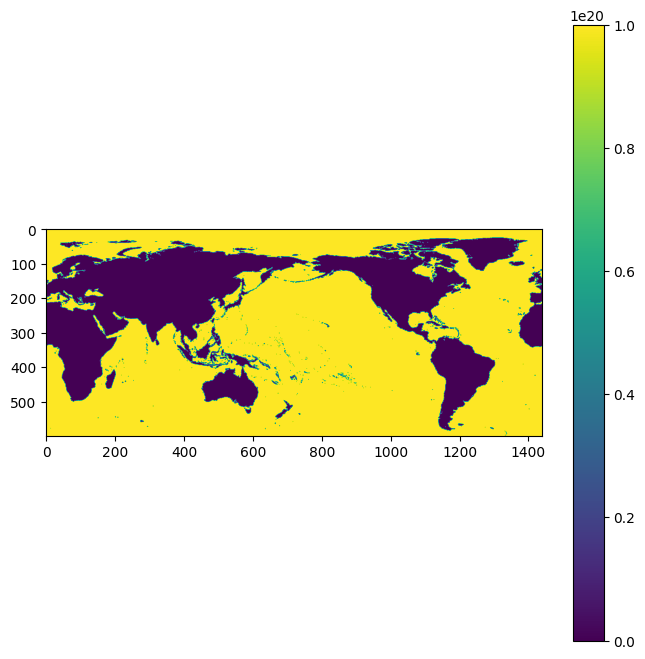

old-size=277,751,427 new-size=1,261,508,620 perc=454.19%


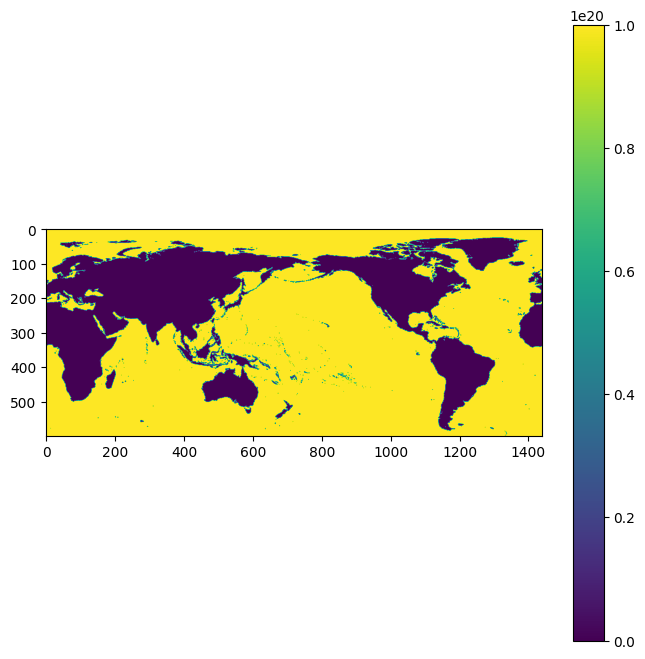

In [4]:
ds = xr.open_dataset(f"{tmp_directory}/full.nc", group="/", mask_and_scale=False)
ShowImage(ds["hurs"][360,...].values)

CopyNetCDF(
  f"{tmp_directory}/full.nc", 
  f"{tmp_directory}/tmp6.nc", 
  variable_mappings={"hurs":field},  
  root_attributes={"example":"my-value"},
  streamable=False)

ds = xr.open_dataset(f"{tmp_directory}/tmp6.nc", group="/", mask_and_scale=False) 
ShowImage(ds[field][360,...].values)

# Write IDX

In [5]:
import datetime

idx_filename=f"{tmp_directory}/visus.idx"
arco="2mb"

visus_data_dir=os.path.splitext(idx_filename)[0]	
print(f"DANGEROUS but needed: removing any old data file from directory={visus_data_dir}")
import shutil
shutil.rmtree(visus_data_dir, ignore_errors=True)

ds = xr.open_dataset(f"{tmp_directory}/full.nc", group="/", mask_and_scale=False) 
data=ds["hurs"][...].values
vmin,vmax=np.min(data),np.max(data)
print(data.shape,data.dtype,vmin,vmax)

ov_field=ov.Field.fromString(f"""{field} {str(data.dtype)} format(row_major) min({vmin}) max({vmax})""")

D,H,W=data.shape
assert(D==365) 

db=ov.CreateIdx(
	url=idx_filename, 
	dims=[W,H], 
	fields=[ov_field], 
	compression="raw", 
	arco=arco,
	time=[timestep,timestep+D,"time_%d/"],
)

for Z in range(D):
	slice=data[Z,...]
	db.write(slice,time=timestep+Z,field=field)

db.compressDataset(["zip"])

DANGEROUS but needed: removing any old data file from directory=./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus
(365, 600, 1440) float32 -58.728542 1e+20
181552094 DiskAccess:111 22628:17976 DiskAccess using existing IdxFile at ./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx
181552094 DiskAccess:140 22628:17976 Created DiskAccess local_idx_filename ./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx filename_template c:/projects/openvisuspy/notebooks/nasa/./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus/$(time)/$(field)/$(block:%016x:%04x).bin compression bDisableWriteLocks False
181552128 DiskAccess:111 22628:17976 DiskAccess using existing IdxFile at ./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx
181552128 DiskAccess:140 22628:17976 Created DiskAccess local_idx_filename ./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx filename_template c:/projects/openvisuspy/noteboo

# Check OpenVisus data

181719731 DiskAccess:111 22628:17976 DiskAccess using existing IdxFile at ./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx
181719732 DiskAccess:140 22628:17976 Created DiskAccess local_idx_filename ./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx filename_template c:/projects/openvisuspy/notebooks/nasa/./remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus/$(time)/$(field)/$(block:%016x:%04x).bin compression bDisableWriteLocks False


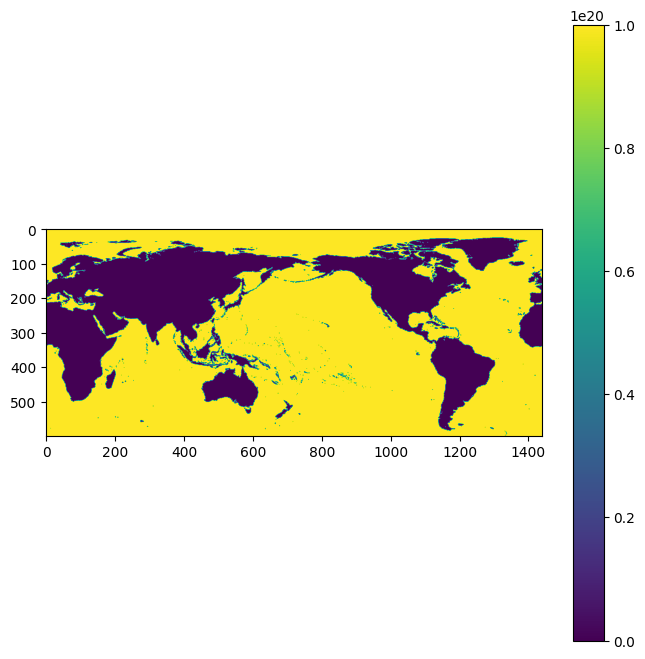

In [6]:
db=ov.LoadDataset(f"{tmp_directory}/visus.idx")
data=db.read(time=711750+360)
ShowImage(data)

# Create Streamable NETCDF

The Streamable.Create above does not work for `*.nc` file, so I am using netCDF4 library here

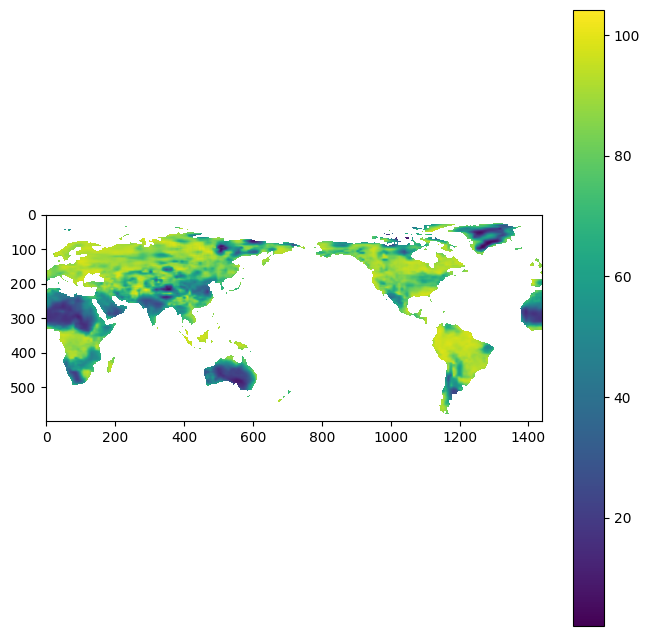

old-size=277,751,427 new-size=1,261,509,946 perc=454.19%
 /
   @idx_urls=b"{'default': 'remote', 'local': './remove-me/hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn_1950/visus.idx', 'remote': 'https://maritime.sealstorage.io/api/v0/s3/utah/nex-gddp-cmip6/visus.idx?cached=arco&access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco'}"
   @idx_url=b'remote'
   @activity=b'NEX-GDDP-CMIP6'
   @contact=b'Dr. Rama Nemani: rama.nemani@nasa.gov, Dr. Bridget Thrasher: bridget@climateanalyticsgroup.org'
   @Conventions=b'CF-1.7'
   @creation_date=b'2021-10-04T13:59:21.654137+00:00'
   @frequency=b'day'
   @institution=b'NASA Earth Exchange, NASA Ames Research Center, Moffett Field, CA 94035'
   @variant_label=b'r1i1p1f1'
   @product=b'output'
   @realm=b'atmos'
   @source=b'BCSD'
   @scenario=b'historical'
   @references=b'BCSD method: Thrasher et al., 2012, Hydrol. Earth Syst. Sci.,16, 3309-3314. Ref period obs: latest version of the Princeton Global Meteor

In [8]:
ds = xr.open_dataset(f"{tmp_directory}/full.nc")
ShowImage(ds["hurs"][360,...].values)

idx_urls={
	"default": "remote",
	"local":  f"{tmp_directory}/visus.idx", 
	"remote": "https://maritime.sealstorage.io/api/v0/s3/utah/nex-gddp-cmip6/visus.idx?cached=arco&access_key=any&secret_key=any&endpoint_url=https://maritime.sealstorage.io/api/v0/s3&cached=arco"
}

CopyNetCDF(
  f"{tmp_directory}/full.nc",
  f"{tmp_directory}/streamable101.nc", 
	variable_mappings={
		"hurs":field
	}, 
	root_attributes={
		"idx_urls": idx_urls,
		"idx_url":  idx_urls["default"],
	},
	streamable=False,
)

Streamable.Print(f"{tmp_directory}/streamable101.nc")


In [ ]:

ds = xr.open_dataset(f"{tmp_directory}/streamable12.nc",engine=OpenVisusBackendEntrypoint, prefer="local")
ShowImage(ds["hurs_day_ACCESS-CM2_historical_r1i1p1f1_gn"].values)